In [1]:
from src.distance_measures import analyse_image
from src.gaussian_noise import generate_noise,generate_noise_tensor
from src.preprocessing import process_image
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
import torch.nn as nn

In [2]:
size = 300
thresh_ = Variable(torch.tensor(0.3, requires_grad=True, dtype=torch.float64))
disk_ = Variable(torch.tensor(4., requires_grad=True, dtype=torch.float64))

In [3]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        self.size = size

        # Define thresh and disk as parameters of the model
        self.thresh = nn.Parameter(thresh_)
        self.disk = nn.Parameter(disk_)

    def forward(self, x):
        noise = generate_noise_tensor(size=self.size, threshold=self.thresh, disk_size=self.disk)
        F, G = analyse_image(noise[0].item(), L=50)
        return torch.tensor(F/G)

# def model(x,thresh,disk):
#     noise = generate_noise(size=size, threshold=thresh.item(), disk_size=disk.item())
#     F, G = analyse_image(noise[0], L=50)
#     return torch.tensor(F/G)

In [4]:
im = process_image('images/1carr-96etoh-alexa-sted-decon.tif', threshold=thresh_.item(), size=size)
F, G = analyse_image(im, L=50)

x = torch.arange(len(F), dtype=torch.float64)
y = torch.tensor(F/G)

In [5]:
learning_rate = 0.01
model = MyModel()
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [7]:
num_epochs = 100
loss_BGD = []

for epoch in range(num_epochs):
    # Forward pass
    y_pred = model(x)
    # print(y_pred)
    # print(type(y_pred[0]),type(y))
    loss = loss_fn(y_pred, y)
    
    # We record loss for plotting
    loss_BGD.append(loss.item())
    # loss = Variable(loss, requires_grad = True)

    # Backward pass and optimization
    optimizer.zero_grad()
    # thresh.retain_grad()
    # disk.retain_grad()
    loss.requires_grad = True
    loss.backward([model.thresh,model.disk])
    optimizer.step()
    
    # loss.backward()
    # thresh.data = thresh.data - learning_rate * thresh.grad.data
    # disk.data = disk.data - learning_rate * disk.grad.data
    # thresh.grad.data.zero_()
    # disk.grad.data.zero_()
    
    # Print the loss at every 10th epoch
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
        # print(model.thresh.item())
        for name, param in model.named_parameters():
            print(name, param.data)

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define a simple model
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(10, 5)
        self.fc2 = nn.Linear(5, 1)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Create an instance of the model
model = MyModel()

# Define some dummy input and target data
x = torch.randn((1, 10))
y = torch.randn((1, 1))

# Define the loss function and the optimizer
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# Print the initial parameter values
print("Initial parameter values:")
for name, param in model.named_parameters():
    print(name, param.data)

# Perform a single optimization step
optimizer.zero_grad()
y_pred = model(x)
loss = loss_fn(y_pred, y)
loss.backward()
optimizer.step()

# Print the updated parameter values
print("\nUpdated parameter values:")
for name, param in model.named_parameters():
    print(name, param.data)


Initial parameter values:
fc1.weight tensor([[-0.2864, -0.1853, -0.1542, -0.2177, -0.1727, -0.0148,  0.1753, -0.0745,
          0.1246,  0.0965],
        [ 0.2595,  0.0579,  0.2301,  0.1753, -0.1569, -0.0569, -0.2550, -0.3146,
         -0.1283,  0.2575],
        [ 0.1956, -0.2249,  0.1018,  0.2833, -0.3037,  0.1461, -0.2240,  0.2924,
          0.1818, -0.1495],
        [-0.1696,  0.0598,  0.2510, -0.2726, -0.3077,  0.2233,  0.2790,  0.1322,
          0.0399, -0.2261],
        [ 0.1273,  0.1533,  0.2294, -0.2583,  0.2358,  0.0250, -0.3118,  0.1323,
         -0.2452, -0.0936]])
fc1.bias tensor([ 0.3132, -0.0806,  0.0940,  0.2716,  0.1903])
fc2.weight tensor([[ 0.0590, -0.1992,  0.0200,  0.2800,  0.2049]])
fc2.bias tensor([0.0244])

Updated parameter values:
fc1.weight tensor([[-0.3039, -0.1831, -0.1443, -0.2013, -0.1608, -0.0132,  0.1823, -0.0726,
          0.1287,  0.0955],
        [ 0.3186,  0.0503,  0.1969,  0.1199, -0.1972, -0.0625, -0.2787, -0.3208,
         -0.1423,  0.2611],
     

In [ ]:
with torch.no_grad():
    y_pred = model(x)
    print(f"Predicted y:\n{y_pred}")

Predicted y:
tensor([0.0000, 0.0000, 0.0112, 0.0301, 0.0375, 0.0405, 0.0416, 0.0401, 0.0391,
        0.0397, 0.0404, 0.0414, 0.0421, 0.0430, 0.0435, 0.0441, 0.0446, 0.0452,
        0.0456, 0.0462, 0.0467, 0.0471, 0.0475, 0.0479, 0.0482, 0.0483, 0.0483,
        0.0483, 0.0481, 0.0479, 0.0477, 0.0477, 0.0475, 0.0474, 0.0473, 0.0472,
        0.0472, 0.0472, 0.0471, 0.0470, 0.0470, 0.0469, 0.0468, 0.0466, 0.0465,
        0.0465, 0.0465, 0.0466, 0.0467, 0.0467, 0.0468], dtype=torch.float64)


In [ ]:
optimizer.parameters()

AttributeError: 'SGD' object has no attribute 'parameters'

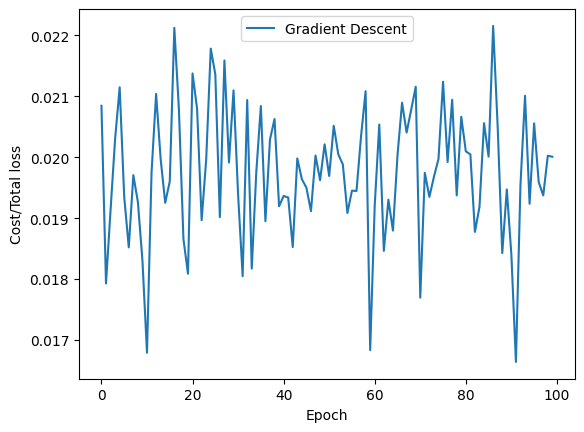

In [ ]:
plt.plot(loss_BGD, label="Gradient Descent")
plt.xlabel('Epoch')
plt.ylabel('Cost/Total loss')
plt.legend()
plt.show()

In [ ]:
thresh.item()
disk.item()

4.0

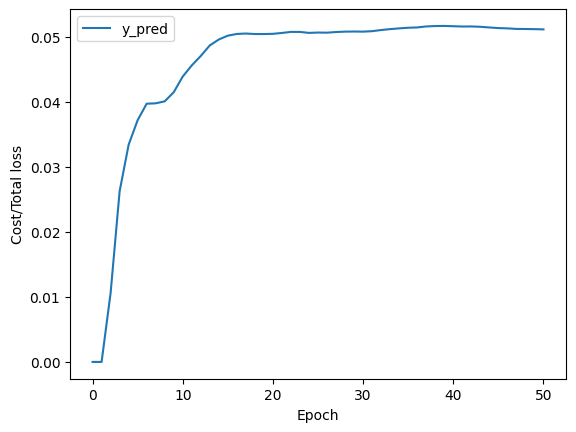

In [ ]:
plt.plot(y_pred, label="y_pred")
plt.xlabel('Epoch')
plt.ylabel('Cost/Total loss')
plt.legend()
plt.show()